# Within-Batch Semi-Hard Negative Mining

In this notebook, we'll get a quick feel for negative mining, the process by which we make triplet examples more difficult for the network.  We'll start by producing some synthetic data representing our a batch of `(anchor, positive, negative)` triplets.

In [105]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9.0, 9.0)

batch_size = 32
n_dim = 128

def get_batch(batch_size, n_dim):
    """
    Produce batches of synthetic embeddings that lie 
    on the unit sphere
    """
    x = np.random.normal(0, 1, (batch_size, n_dim))
    x /= np.linalg.norm(x, axis=-1, keepdims=True) + 1e-8
    return x

def cosine_distance(a, b):
    """
    Compute the cosine distance of vector pairs from 
    a and b, assuming that all vectors lie on the unit 
    sphere
    """
    return 1 - (a * b).sum(axis=-1)

anchors = get_batch(batch_size, n_dim)
positives = get_batch(batch_size, n_dim)
negatives = get_batch(batch_size, n_dim)

# Mining for Negatives

Here's how the paper [UNSUPERVISED LEARNING OF SEMANTIC AUDIO REPRESENTATIONS](https://arxiv.org/pdf/1711.02209.pdf) describes the technique:

>Here, all examples in the batch are transformed under
the current state of g, and the available negatives are reassigned to
the anchor-positive pairs to make more difficult triplets. Specifically,
we choose the closest negative to the anchor that is still further away
than the positive (the absolute closest is vulnerable to label noise)

This is synthetic data, so all the anchor-to-positive and anchor-to-negative distances are very close, but we can imagine that with our naive randomly sampled triplets, negative examples might almost always be very easy, or may occasionally be closer to the anchor than the positive example.

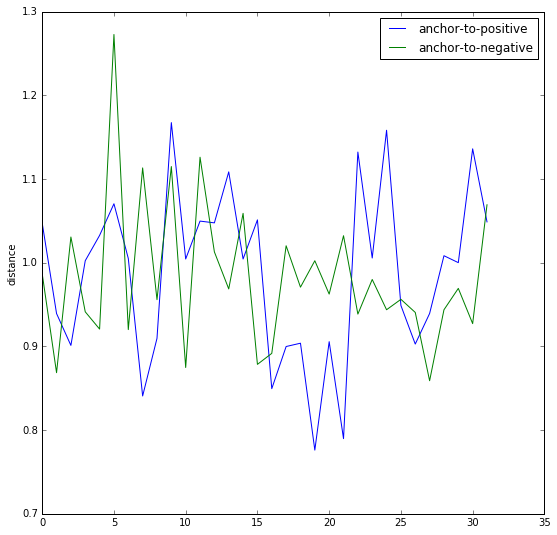

In [106]:
# first, compute distances between anchors and positive
# examples
anchor_to_positive_distances = cosine_distance(anchors, positives)
naive_anchor_to_negative_distances = cosine_distance(anchors, negatives)
plt.plot(anchor_to_positive_distances, label='anchor-to-positive')
plt.plot(naive_anchor_to_negative_distances, label='anchor-to-negative')
plt.ylabel('distance')
plt.legend()

# The Technique

We'll compute all the pairwise distances between the positive and negative examples, and reorder the negative examples so they're paired the anchor they're nearest, without being closer than the corresponding positive example.

Note that this technique for computing the best negative examples allows for some examples to be used in multiple triplets.

In [107]:
# compute the distance between every possible (anchor, negative) pair
dist_matrix = cdist(anchors, negatives, metric='cosine')

# subtract the anchor-to-positive distances, and clip negative values, 
# since we don't want to choose negatives that are closer than the 
# positives
diff = dist_matrix - anchor_to_positive_distances[:, None]
FLOAT_MAX = np.finfo(diff.dtype).max
diff[diff <= 0] = FLOAT_MAX

# For each anchor, find the negative example that is closest, without
# being closer than the positive example
indices = np.argmin(diff, axis=-1)
print 'Best Indices:', indices

Best Indices: [16  6 19 14  7  0  7  3 29 12 12 16 29  2 12  8 23 30  9 21 21 14  4 17
  0 29  8  3 30 18 13 18]


# Newly Aligned Negative Examples

Finally, if we compare the anchor-to-positive distances with distances to the more difficult negative examples, we see that they're very closely aligned.

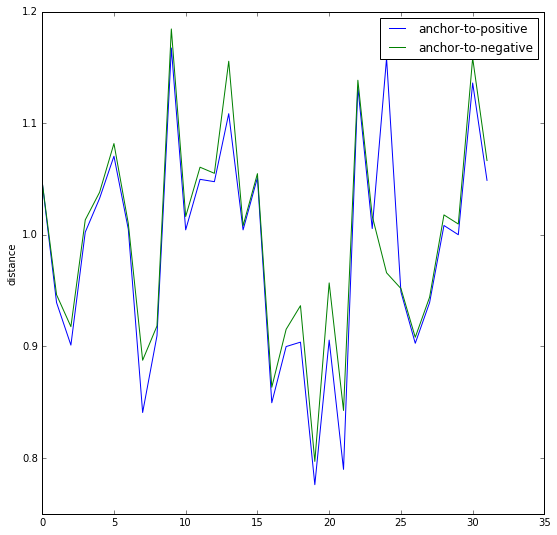

In [108]:
negative_distances = cosine_distance(anchors, negatives[indices])
plt.plot(anchor_to_positive_distances, label='anchor-to-positive')
plt.plot(negative_distances, label='anchor-to-negative')
plt.ylabel('distance')
plt.legend()